```python
Q01
```

Parameters of the largest circle:
Radius: 52.72996282562541 pixels
Center coordinates: ( 0.0 , 241.0 )
Sigma range used: from 2 to 40


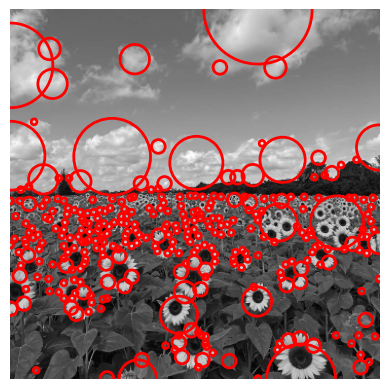

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log

# Load the image
image_path = "the_berry_farms_sunflower_field.jpeg"
im = cv.imread(image_path, cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Blob detection
blobs = blob_log(gray_im, min_sigma=2, max_sigma=40, num_sigma=15, threshold=.1)

# Get the radius of the largest blob
largest_radius = max(blobs[:, 2])
blobs[:, 2] = blobs[:, 2] * math.sqrt(2)

# Get the radius after adjusting with sqrt(2)
adjusted_radius = max(blobs[:, 2])
x0, y0, r = blobs[np.where(blobs[:, 2] == adjusted_radius)[0][0]]

# Plot the image
fig, ax = plt.subplots()
ax.imshow(gray_im, cmap='gray')
ax.axis('off')

# Plot all blobs
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

# Print the parameters of the largest circle
print("Parameters of the largest circle:")
print("Radius:", adjusted_radius, "pixels")
print("Center coordinates: (", x0, ",", y0, ")")
print("Sigma range used: from 2 to 40")

plt.show()


implementing RANSAC Line

iteration 6
line_best_error 11.128268953610695
best_line_indices [53 62]
best_line_model [0.71741534 0.69664571 1.30451795]
no of inliers 47

iteration 23
line_best_error 10.349584792453937
best_line_indices [71 85]
best_line_model [0.71786527 0.69618206 1.07884973]
no of inliers 44

iteration 27
line_best_error 9.594626309350883
best_line_indices [99 97]
best_line_model [0.71669248 0.69738934 1.06098972]
no of inliers 43

iteration 46
line_best_error 8.815434223354965
best_line_indices [61 93]
best_line_model [0.72017588 0.69379156 1.08416483]
no of inliers 42

implementing RANSAC Circle


no of elements in X 100
no of inliers 42
remnants 58

iteration 7
best_error 6.967506416102412
best_indecies [35 13 10]
best_model [ 2.04060167  3.07659564 10.05201544]
no of inliers 47

iteration 13
best_error 4.183375793250296
best_indecies [56  7 43]
best_model [ 2.2562353   3.23724863 10.22141103]
no of inliers 41

iteration 19
best_error 3.977852676399003
best_indecies

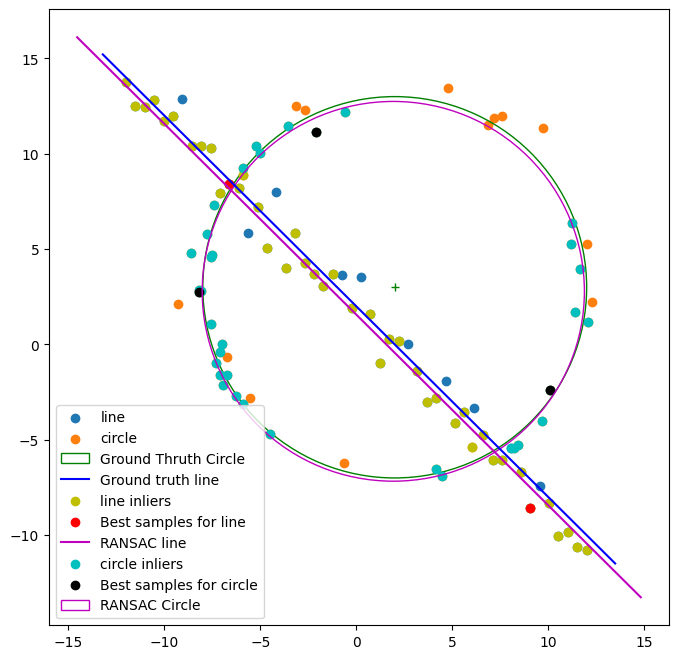

In [5]:
# Generation of a Noisy Point Set Conforming to a Line and a Circl e
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib
# np . random . seed ( 0)
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace(-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # All point s
fig , ax = plt.subplots (1 ,1 , figsize=(8 ,8))
ax . scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label = 'circle')
circle_get = plt.Circle( ( x0_gt , y0_gt ) , r , color = 'g', fill=False , label='Ground Thruth Circle' )
ax . add_patch (circle_get)
ax . plot ( ( x0_gt ) , ( y0_gt ) ,'+', color = 'g' )
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot ( x_ , y_ ,color = 'b' , label= 'Ground truth line' )
plt.legend ( )


#implementing RANSAC Line

N = X.shape[0]  # number of points
X = X # data matrix
print('implementing RANSAC Line')

#total least square erorr for line
def line_total_error(x,line_indices):
    a,b,d = x[0],x[1],x[2]
    return np.sum(np.square(a*X[line_indices,0]+b*X[line_indices,1]-d))

#constraint
def cons(x):
    return x[0]**2+x[1]**2-1

constraint = ({'type':'eq','fun':cons})

#consensus set
def line_consensus_set(X,x,line_threshold):
    a,b,d = x[0],x[1],x[2]
    error = np.abs(a*X[:,0]+b*X[:,1]-d)
    return error<line_threshold

line_max_iterartion = 100
line_threshold = 1.
line_data_points = 0.4*N
line_best_error = np.inf
line_sample = 2

best_line_indices = []
best_line_model = []
line_inlinears = []
best_line_inliers = []   
line_iteration = 0

while line_iteration< line_max_iterartion:
    line_indices = np.random.randint(0,N,line_sample)  #randomly select s points
    x0 = np.array([1,1,0]) #initial guess
    res = minimize(line_total_error,x0=x0,args=(line_indices),tol= 1e-6,constraints=constraint) #minimize the error
    line_inlinears = line_consensus_set(X,res.x,line_threshold)  #find the consensus set
    if np.sum(line_inlinears) > line_data_points:
        x0 = res.x
        res = minimize(line_total_error, x0=x0, args=(line_inlinears),tol= 1e-6, constraints=constraint) #refit the model
        if res.fun < line_best_error:
            print('\niteration',line_iteration)
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inlinears
            print('line_best_error',line_best_error)
            print('best_line_indices',best_line_indices)
            print('best_line_model',best_line_model)
            print('no of inliers',np.sum(best_line_inliers))

    line_iteration+= 1

ax.scatter(X[best_line_inliers,0],X[best_line_inliers,1],color='y',label='line inliers')
ax.scatter(X[best_line_indices,0],X[best_line_indices,1],color='r',label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1]*x_ + best_line_model[2])/best_line_model[1]
plt.plot(x_, y_, color ='m', label='RANSAC line')
ax.legend()


#implementing RANSAC Circle
print('\nimplementing RANSAC Circle')
print('\n')
print('no of elements in X',len(X))
print('no of inliers',np.sum(best_line_inliers))

line_outliers = np.where(best_line_inliers==False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('remnants',len(remnants))

def circle_tls(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

def circle_consenus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    # Count number of inliers
    return distances < circle_threshold

circle_threshold = 1.
max_circle_iterations = 100
circle_best_model = []
circle_best_inliers = []
circle_best_error = np.inf
circle_best_indecies = []
circle_iteration = 0
circle_sample =3
circle_num_data = 35

while circle_iteration < max_circle_iterations:
    circle_indicies = np.random.randint(0,len(remnants), circle_sample)
    x0 = np.array([0,0,0]) #initial guess
    res = minimize(circle_tls, x0, args=circle_indicies, tol=1e-6) #minimize the error
    circle_inliers = circle_consenus_set(remnants, res.x, circle_threshold)  #find the consensus set


    if np.sum(circle_inliers) > circle_num_data:
            x0 = res.x
            res = minimize(circle_tls, x0=x0, args=(circle_inliers),tol= 1e-6)
            if res.fun < circle_best_error:
                print('\niteration',circle_iteration)
                circle_best_error = res.fun
                circle_best_indecies = circle_indicies
                circle_best_model = res.x
                circle_best_inliers = circle_inliers
                print('best_error',circle_best_error)
                print('best_indecies',circle_best_indecies)
                print('best_model',circle_best_model)
                print('no of inliers',np.sum(circle_best_inliers))
                # best_model = res.x
                # best_inliers = inliers
                # best_indecies = indices
    circle_iteration += 1


ax.scatter(remnants[circle_best_inliers,0],remnants[circle_best_inliers,1],color='c',label='circle inliers')
ax.scatter(remnants[circle_best_indecies,0],remnants[circle_best_indecies,1],color='k',label='Best samples for circle')
circle = plt.Circle((circle_best_model[0],circle_best_model[1]),circle_best_model[2],color='m',fill=False,label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()

Homography matrix:
[[ 4.93940938e+00  2.16416165e-01 -5.89686453e+02]
 [ 1.54900540e+00  4.20619706e+00 -8.85437809e+02]
 [ 8.03875589e-03  4.71547170e-04  1.00000000e+00]]


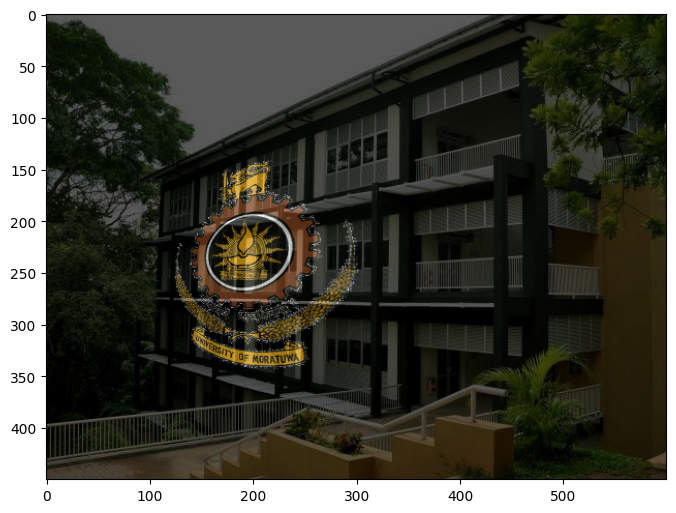

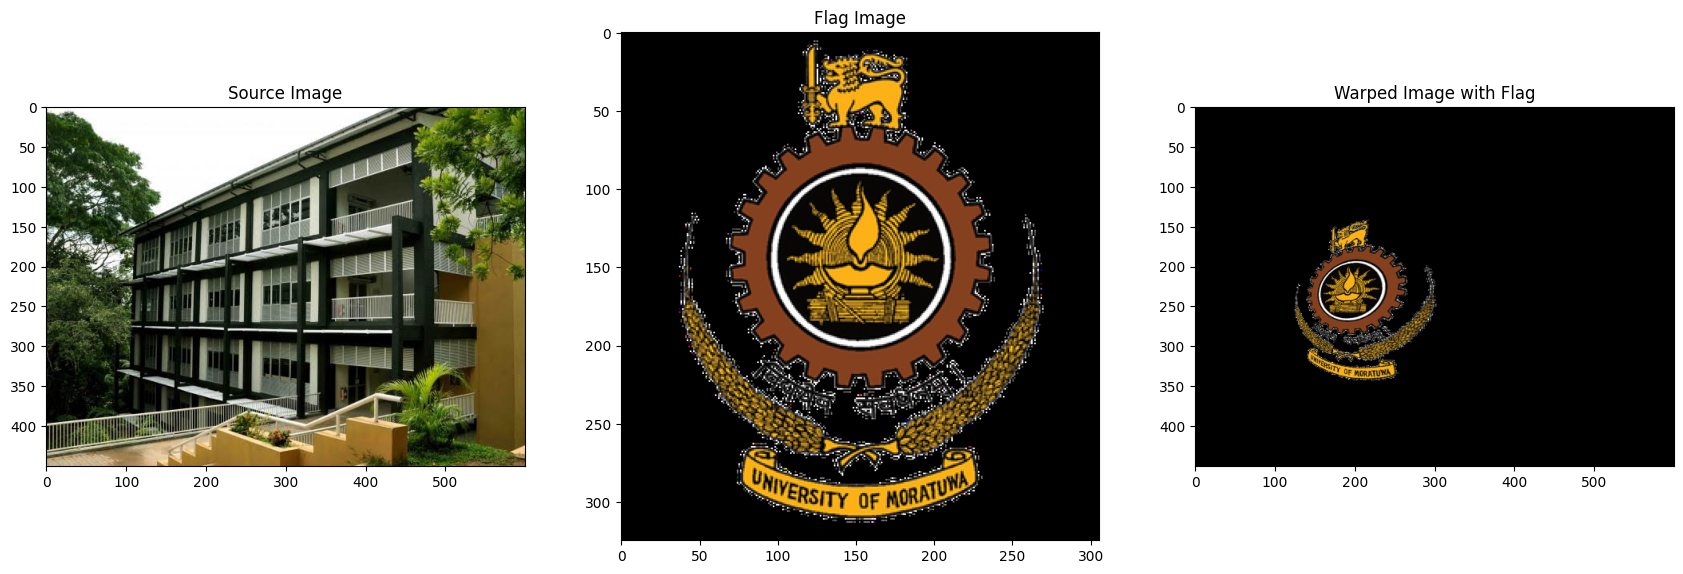

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Number of points
N = 4

# Counter for points
global n
n = 0

# Parameters of the two images
points_source = np.empty((N, 2))
points_flag = np.empty((N, 2))

# Mouse callback function to draw circles on the image
def draw_circle(event, x, y, flags, param):
    global n
    points = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        points[n] = (x, y)
        n += 1

# Importing the images and creating copies
source_image = cv2.imread('UOM_1.jpg', cv2.IMREAD_COLOR)
flag_image = cv2.imread('University_of_Moratuwa_logo.png', cv2.IMREAD_COLOR)
source_image_copy = source_image.copy()
flag_image_copy = flag_image.copy()

cv2.namedWindow('Source Image', cv2.WINDOW_AUTOSIZE)
param_source = [points_source, source_image_copy]
cv2.setMouseCallback('Source Image', draw_circle, param_source)

# Collecting points on the source image
while(1):
    cv2.imshow('Source Image', source_image_copy)
    if n == N:
        break
    if cv2.waitKey(20) & 0xFF == 27:
        break

# Reset point counter for flag image
n = 0

cv2.namedWindow('Flag Image', cv2.WINDOW_AUTOSIZE)
param_flag = [points_flag, flag_image_copy]
cv2.setMouseCallback('Flag Image', draw_circle, param_flag)

# Collecting points on the flag image
while(1):
    cv2.imshow('Flag Image', flag_image_copy)
    if n == N:
        break
    if cv2.waitKey(20) & 0xFF == 27:
        break

cv2.destroyAllWindows()

# Calculate homography between source image and flag image
h, status = cv2.findHomography(points_source, points_flag)
print("Homography matrix:")
print(h)

# Warp the flag image onto the source image
warped_flag_img = cv2.warpPerspective(flag_image, np.linalg.inv(h), (source_image.shape[1], source_image.shape[0]))

# Blending the images
alpha = 0.35
beta = 1 - alpha
blended_img = cv2.addWeighted(source_image, alpha, warped_flag_img, beta, 0.0)

# Display the blended image
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))

# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv2.cvtColor(flag_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv2.cvtColor(warped_flag_img, cv2.COLOR_BGR2RGB))
ax[2].set_title("Warped Image with Flag")
plt.show()


Q 04

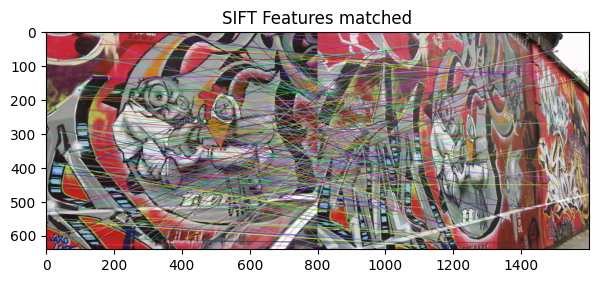

In [9]:
#(a)

import cv2 as cv
import matplotlib.pyplot as plt

# Load the input images
im1 = cv.imread("img1.ppm")
im5 = cv.imread("img5.ppm")

# Create a SIFT object
sift = cv.SIFT_create()

# Detect keypoints and compute descriptors
kp1, dcrip1 = sift.detectAndCompute(im1, None)
kp2, dcrip2 = sift.detectAndCompute(im5, None)

# Feature matching
bf_matcher = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = sorted(bf_matcher.match(dcrip1, dcrip2), key=lambda x: x.distance)

# Draw matches between images
mtch_img = cv.drawMatches(im1, kp1, im5, kp2, matches[:250], im5, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display using matplotlib
fig, ax = plt.subplots(figsize=(7, 7))
matched_image_rgb = cv.cvtColor(mtch_img, cv.COLOR_BGR2RGB)
ax.set_title("SIFT Features matched")
ax.imshow(matched_image_rgb)
plt.show()

Computed Homography =  [[ 6.16655592e-01  5.00895382e-02  2.24338908e+02]
 [ 2.14419520e-01  1.14093554e+00 -2.34796091e+01]
 [ 4.76175931e-04 -7.02559927e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



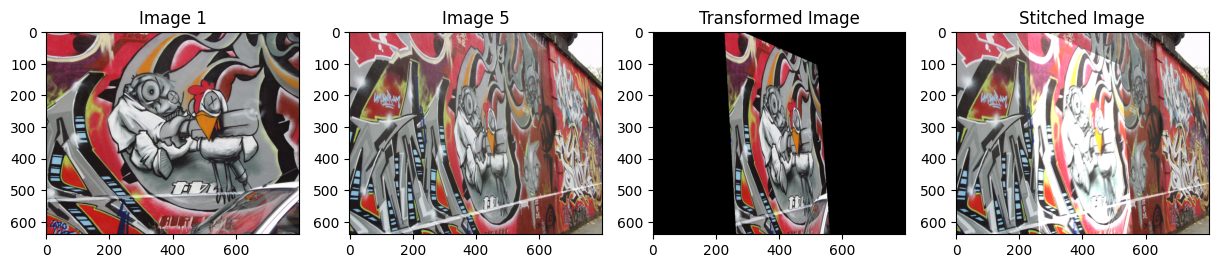

In [11]:
#(b) and (c)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale images
image1_gray = cv.cvtColor(cv.imread("img1.ppm"), cv.COLOR_BGR2GRAY)
image2_gray = cv.cvtColor(cv.imread("img2.ppm"), cv.COLOR_BGR2GRAY)
image3_gray = cv.cvtColor(cv.imread("img3.ppm"), cv.COLOR_BGR2GRAY)
image4_gray = cv.cvtColor(cv.imread("img4.ppm"), cv.COLOR_BGR2GRAY)
image5_gray = cv.cvtColor(cv.imread("img5.ppm"), cv.COLOR_BGR2GRAY)

# Images list
gray_img = [image1_gray, image2_gray, image3_gray, image4_gray, image5_gray]

# Calculating the homography matrix
def cal_homo(src_pts, des_pts):
    x1, y1, x2, y2, x3, y3, x4, y4 = des_pts[0], des_pts[1], des_pts[2], des_pts[3], des_pts[4], des_pts[5], des_pts[6], des_pts[7]
    x1T, x2T, x3T, x4T = src_pts[0], src_pts[1], src_pts[2], src_pts[3]
    null = np.array([[0], [0], [0]])

    A = np.concatenate((np.concatenate((null.T, x1T, -y1 * x1T), axis=1),
                        np.concatenate((x1T, null.T, -x1 * x1T), axis=1),
                        np.concatenate((null.T, x2T, -y2 * x2T), axis=1),
                        np.concatenate((x2T, null.T, -x2 * x2T), axis=1),
                        np.concatenate((null.T, x3T, -y3 * x3T), axis=1),
                        np.concatenate((x3T, null.T, -x3 * x3T), axis=1),
                        np.concatenate((null.T, x4T, -y4 * x4T), axis=1),
                        np.concatenate((x4T, null.T, -x4 * x4T), axis=1)), axis=0, dtype=np.float64)
    
    W, v = np.linalg.eig(((A.T) @ A))
    h = v[:, np.argmin(W)]
    H = h.reshape((3, 3))
    return H

# Generate random numbers between 0 and n-1 without repetition
def rand_num(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))

    for i in range(len(l)):
        m[i] = np.sum(l == l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return rand_num(n, t)

confidence = 0.99  
subset_size = 4  
epsilon = 0.5   

# Compute the number of RANSAC iterations needed
num_iter = int(np.ceil(np.log(1 - confidence) / np.log(1 - ((1 - epsilon) ** subset_size))))
homographies = []
for i in range(4):
    sift = cv.SIFT_create()
    kp1, dcript1 = sift.detectAndCompute(gray_img[i], None)  # SIFT feature detection
    kp2, dcript2 = sift.detectAndCompute(gray_img[i + 1], None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  # Feature matching
    matches = sorted(bf_match.match(dcript1, dcript2), key=lambda x: x.distance)

    src_pts = [kp1[k.queryIdx].pt for k in matches]
    des_pts = [kp2[k.trainIdx].pt for k in matches]
    threshold = 2
    best_inliers = 0
    best_homography = 0

    for _ in range(num_iter):
        rand_indices = rand_num(len(src_pts) - 1, 4)
        rand_source = []
        rand_destination = []

        for j in range(4):
            rand_source.append(np.array([[src_pts[rand_indices[j]][0],
                                                  src_pts[rand_indices[j]][1], 1]]))
            rand_destination.append(des_pts[rand_indices[j]][0])
            rand_destination.append(des_pts[rand_indices[j]][1])

        H = cal_homo(rand_source, rand_destination)

        inliers = 0
        for k in range(len(src_pts)):
            X = [src_pts[k][0], src_pts[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0] - des_pts[k][0], 2) + np.power(HX[1] - des_pts[k][1], 2))
            if err < threshold:
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_homography = H

    homographies.append(best_homography)

H1_to_H5 = homographies[3] @ homographies[2] @ homographies[1] @ homographies[0]
H1_to_H5 /= H1_to_H5[-1][-1]

print("Computed Homography = ", H1_to_H5)
print("Provided Homography = ", open("H1to5p", 'r').read())

transformed_image1 = cv.warpPerspective(cv.imread("img1.ppm"), H1_to_H5, (np.shape(cv.imread("img5.ppm"))[1], np.shape(cv.imread("img5.ppm"))[0]))
stitched_image = cv.add(cv.imread("img5.ppm"), transformed_image1)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(cv.cvtColor(cv.imread("img1.ppm"), cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(cv.imread("img5.ppm"), cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(transformed_image1, cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Image")
ax[3].imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB)), ax[3].set_title("Stitched Image")
plt.show()